In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

In [2]:
d = pd.read_csv('./rethinking/data/Trolley.csv', sep=';')

In [3]:
d.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


NameError: name 'd_res' is not defined

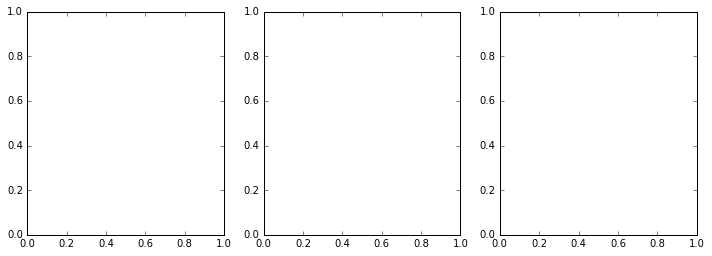

In [4]:
fig, (ax_l, ax_c, ax_r) = plt.subplots(1, 3, figsize=(12,4))

# left plot
d_res.plot(ax=ax_l, kind='bar')

prop = d_res.div(d_res.sum())

# center plot
cum_prop = prop.cumsum() 
cum_prop.plot(ax=ax_c, kind='line')
ax_c.scatter(cum_prop.index, cum_prop.values, facecolors='none', edgecolors='k', s=30)
ax_c.set_ylim([0,1])

# right plot
log_cum_odds = cum_prop.apply(lambda x: x / (1 - x)).apply(np.log)
log_cum_odds.plot(ax=ax_r, kind='line')
ax_r.scatter(log_cum_odds.index, log_cum_odds.values)
ax_r.set_title('Log cumulative odds')

boring


#### 11.3 Over-dispersed outcomes

A beta-binomial model assumes that each binomial count observation has its own probability of a success. The model estimates the distribution of probabilities of success across cases, instead of a single probability of success.

And predictor variables change the shape of this distribution, instead of directly determining the probability of each success.

What a beta-binomial model of these data will assume is that each observed count on each row of the data table has its own unique, unobserved probability of success. These probabilities of success themselves have a common distribution. This distribution is described using a beta distribution, which is a probability distribution for probabilities. 

Why use a beta? Because it makes the mathematics easy. When we use a beta, it is mathematically possible to solve for a closed form likelihood function that averages over the unknown probabilities for each observation. 

A beta distribution has two parameters, an average probability $\bar{p}$ and a shape parameter $\theta$. The shape parameter $\theta$ describes how spread out the distribution is. When $\theta = 2$, every probability from zero to one is equally likely. 

(0, 10)

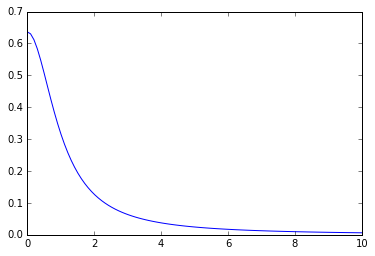

In [5]:
linspace = np.linspace(0, 10, 100)
pd.Series(stats.halfcauchy.pdf(linspace, loc=0, scale=1), index=linspace).plot()
plt.xlim([0, 10])

In [69]:
d = pd.read_csv('./rethinking/data/UCBadmit.csv', sep=';')

In [70]:
d['admit_prob'] = d['admit'] / d['applications']

In [80]:
d['applications'].max()

825

In [83]:
with pm.Model() as m115:
    
    alpha = pm.Normal('alpha', 0, 10)
    theta = pm.HalfCauchy('theta', 1)
    
    loc_beta = np.exp(alpha) / (1 + np.exp(alpha))
    
# beta binomial
#     p = pm.Beta('p', alpha=loc_beta, beta=theta, shape=12)    
#     admit = pm.Binomial('admit', n=d['applications'].values, p=p, observed=d['admit'])
    
    # alpha, beta here are the loc/scale of the beta
    admit = pm.BetaBinomial('admit', 
                            n=d['applications'].values, 
                            alpha=loc_beta, 
                            beta=theta, 
                            observed=d['admit'])
    
    m115_map = pm.find_MAP()
    m115_trace = pm.sample(1000, start=m115_map)

100%|██████████| 1000/1000 [00:01<00:00, 533.77it/s]


In [86]:
m115_trace_df = pm.trace_to_dataframe(m115_trace)

In [94]:
alphas = m115_trace_df.alpha.apply(lambda x: np.exp(x) / (1 + np.exp(x)))

In [96]:
alphas.quantile([0.05, 0.5, 0.975])

0.050    0.800694
0.500    0.999333
0.975    1.000000
Name: alpha, dtype: float64

In [84]:
m115_map

{'alpha': array(3.9433735164881303), 'theta_log_': array(0.4582888365484163)}

In [60]:
np.exp(m115_map['alpha']) / ( 1 + np.exp(m115_map['alpha']))

0.98098582985355598